In [1]:
import warnings
import json
import numpy as np
import pandas as pd
import os
import umap
import umap.plot
import pacmap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
import hdbscan
import plotly.express as px
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category20
from bokeh.themes import built_in_themes
from bokeh.io import output_notebook, curdoc
from bokeh.resources import settings

In [18]:
pd.set_option('display.max_colwidth', 255)
warnings.filterwarnings('ignore')
settings.resources = 'inline'

In [19]:
EXPERIMENT_FOLDER = "C:\\Users\\aprez\\B2Drop\\embeddings\\astro_embeddings\\ld64"
EMBEDDINGS_FILE = "embeddings.json"
LABELS_FILE = "labels.json"
IMAGES_FOLDER = "images"
GENERATED_FOLDER = "generated"

In [20]:
data_path = os.path.join(EXPERIMENT_FOLDER, EMBEDDINGS_FILE)
with open(data_path, 'r') as json_data:
    train_data = np.array(json.load(json_data))
print(train_data.shape)


(178, 64)


In [21]:
reducer=pacmap.PaCMAP(n_components=5, n_neighbors=None, MN_ratio=0.5, FP_ratio=2)
train_data = reducer.fit_transform(train_data)
print(train_data.shape)

(178, 5)


In [22]:
labels_path = os.path.join(EXPERIMENT_FOLDER, LABELS_FILE)
with open(labels_path, 'r') as labels:
    labels = json.loads(labels.read())
    images = labels['columns']
    df_images = pd.DataFrame({'image': images[:]})
    print(df_images[:10])

             image
0  G001.9+00.3.png
1  G003.7-00.2.png
2  G003.8+00.3.png
3  G005.5+00.3.png
4  G006.1+00.5.png
5  G006.1+01.2.png
6  G006.4-00.1.png
7  G006.5-00.4.png
8  G007.0-00.1.png
9  G007.2+00.2.png


In [23]:
images_path = map(lambda image: os.path.join(EXPERIMENT_FOLDER, IMAGES_FOLDER, image), images)
df_images_path = pd.DataFrame({'image_path' : images_path})
df_images_path.head()

,image_path
0,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G001.9+00.3.png
1,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.7-00.2.png
2,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.8+00.3.png
3,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G005.5+00.3.png
4,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G006.1+00.5.png


In [24]:
generated_path = map(lambda generated: os.path.join(EXPERIMENT_FOLDER, GENERATED_FOLDER, generated), images)
df_generated_path = pd.DataFrame({'generated_path' : generated_path})
df_generated_path.head()

,generated_path
0,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G001.9+00.3.png
1,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.7-00.2.png
2,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.8+00.3.png
3,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G005.5+00.3.png
4,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G006.1+00.5.png


In [25]:
df_images = df_images.join(df_images_path)
df_images = df_images.join(df_generated_path)
print(df_images.head())

             image  \
0  G001.9+00.3.png   
1  G003.7-00.2.png   
2  G003.8+00.3.png   
3  G005.5+00.3.png   
4  G006.1+00.5.png   

                                                                      image_path  \
0  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G001.9+00.3.png   
1  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.7-00.2.png   
2  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.8+00.3.png   
3  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G005.5+00.3.png   
4  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G006.1+00.5.png   

                                                                     generated_path  
0  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G001.9+00.3.png  
1  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.7-00.2.png  
2  C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.8+00.3.png  
3  C:\Users\aprez\

In [37]:
def compute_pca(data, n_components, random_state):
    reducer = PCA(n_components=n_components, random_state=random_state)
    df_embedding= pd.DataFrame(reducer.fit_transform(data))
    if (n_components==2):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y"})
    elif(n_components==3):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y", 2:"z"})
    return df_embedding
    
def compute_umap(data, n_components, n_neighbors, min_dist, random_state):
    reducer=umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    df_embedding= pd.DataFrame(reducer.fit_transform(data))
    if (n_components==2):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y"})
    elif(n_components==3):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y", 2:"z"})
    return df_embedding
    
def compute_pacmap(data, n_components, n_neighbors, MN_ratio, FP_ratio):
    reducer = pacmap.PaCMAP(n_components=n_components, n_neighbors=n_neighbors, MN_ratio=MN_ratio, FP_ratio=FP_ratio)
    df_embedding = pd.DataFrame(reducer.fit_transform(data))
    if (n_components==2):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y"})
    elif(n_components==3):
        df_embedding = df_embedding.rename(columns={0:"x", 1:"y", 2:"z"})
    return df_embedding
       
def compute_kmeans(data, n_clusters, random_state):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = pd.DataFrame(kmeans.fit_predict(data))
    clusters = clusters.rename(columns={0:"clusters"})
    return clusters

def compute_dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = pd.DataFrame(dbscan.fit_predict(data))
    clusters = clusters.rename(columns={0:"clusters"})
    return clusters

def compute_hdbscan(data, min_cluster_size):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusters = pd.DataFrame(clusterer.fit_predict(data))
    clusters = clusters.rename(columns={0:"clusters"})
    return clusters

def compute_agglomerative_clustering(data, n_clusters):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = pd.DataFrame(clusterer.fit_predict(data))
    clusters = clusters.rename(columns={0:"clusters"})
    return clusters

def compute_affinity_propagation(data, random_state):
    clusterer = AffinityPropagation(random_state=random_state)
    clusters = pd.DataFrame(clusterer.fit_predict(data))
    clusters = clusters.rename(columns={0:"clusters"})
    return clusters

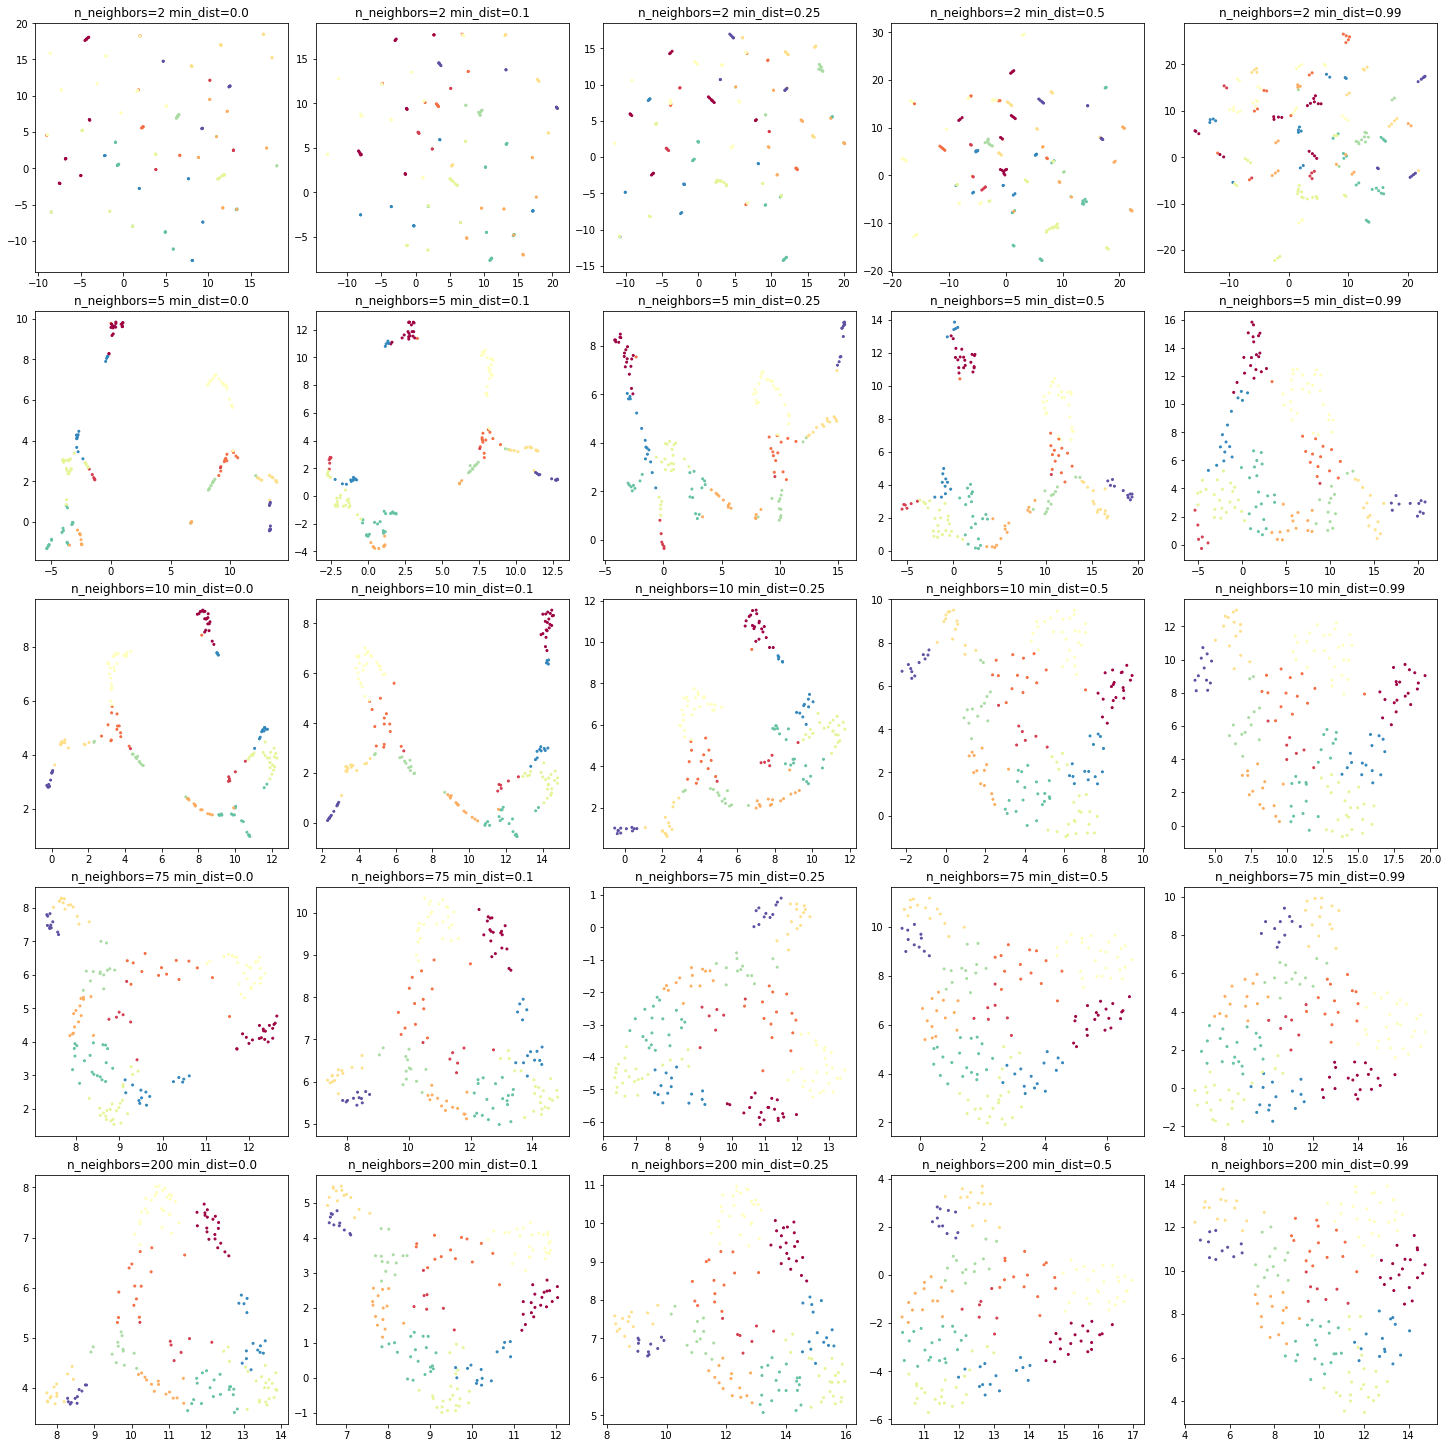

In [56]:
clusters=compute_affinity_propagation(data=train_data, random_state=42)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,20), constrained_layout=True)
for nrow, n in enumerate([2, 5, 10, 75, 200]):
    for ncol, d in enumerate([0.0, 0.1, 0.25, 0.5, 0.99]):
        df_embedding=compute_umap(data=train_data, n_components=2, n_neighbors=n, min_dist=d, random_state=42)
        axs[nrow, ncol].scatter(df_embedding['x'], df_embedding['y'], c=clusters['clusters'], s=4, cmap='Spectral')
        axs[nrow, ncol].set_title('n_neighbors={} '.format(n) + 'min_dist={}'.format(d), fontsize=12)

In [27]:
clusters=compute_affinity_propagation(data=train_data, random_state=42)
df_embedding=compute_pca(data=train_data, n_components=3, random_state=42)
df_embedding = df_embedding.join(df_images)
df_embedding = df_embedding.join(clusters)
df_embedding.head()

,x,y,z,image,image_path,generated_path,clusters
0,-1.990266,2.506405,0.214634,G001.9+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G001.9+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G001.9+00.3.png,0
1,-1.956486,-0.678337,0.108281,G003.7-00.2.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.7-00.2.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.7-00.2.png,9
2,-2.265676,-1.810077,0.790106,G003.8+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.8+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.8+00.3.png,8
3,0.346987,-3.135506,-0.252636,G005.5+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G005.5+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G005.5+00.3.png,3
4,-1.251320,2.432296,0.043963,G006.1+00.5.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G006.1+00.5.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G006.1+00.5.png,0


In [16]:
fig = px.scatter_3d(df_embedding, x = df_embedding['x'], y = df_embedding['y'], z = df_embedding['z'], hover_data={'Image' : df_embedding['image']}, color=df_embedding['clusters'].astype(str), labels={"color": "Cluster"})
fig.update_traces(marker = dict(size=3, line=dict(width=0)))
fig.update_layout(legend = {'itemsizing': 'constant'}, scene = dict(xaxis = dict(showticklabels=False, showspikes=False), yaxis = dict(showticklabels=False, showspikes=False), zaxis = dict(showticklabels=False, showspikes=False)))

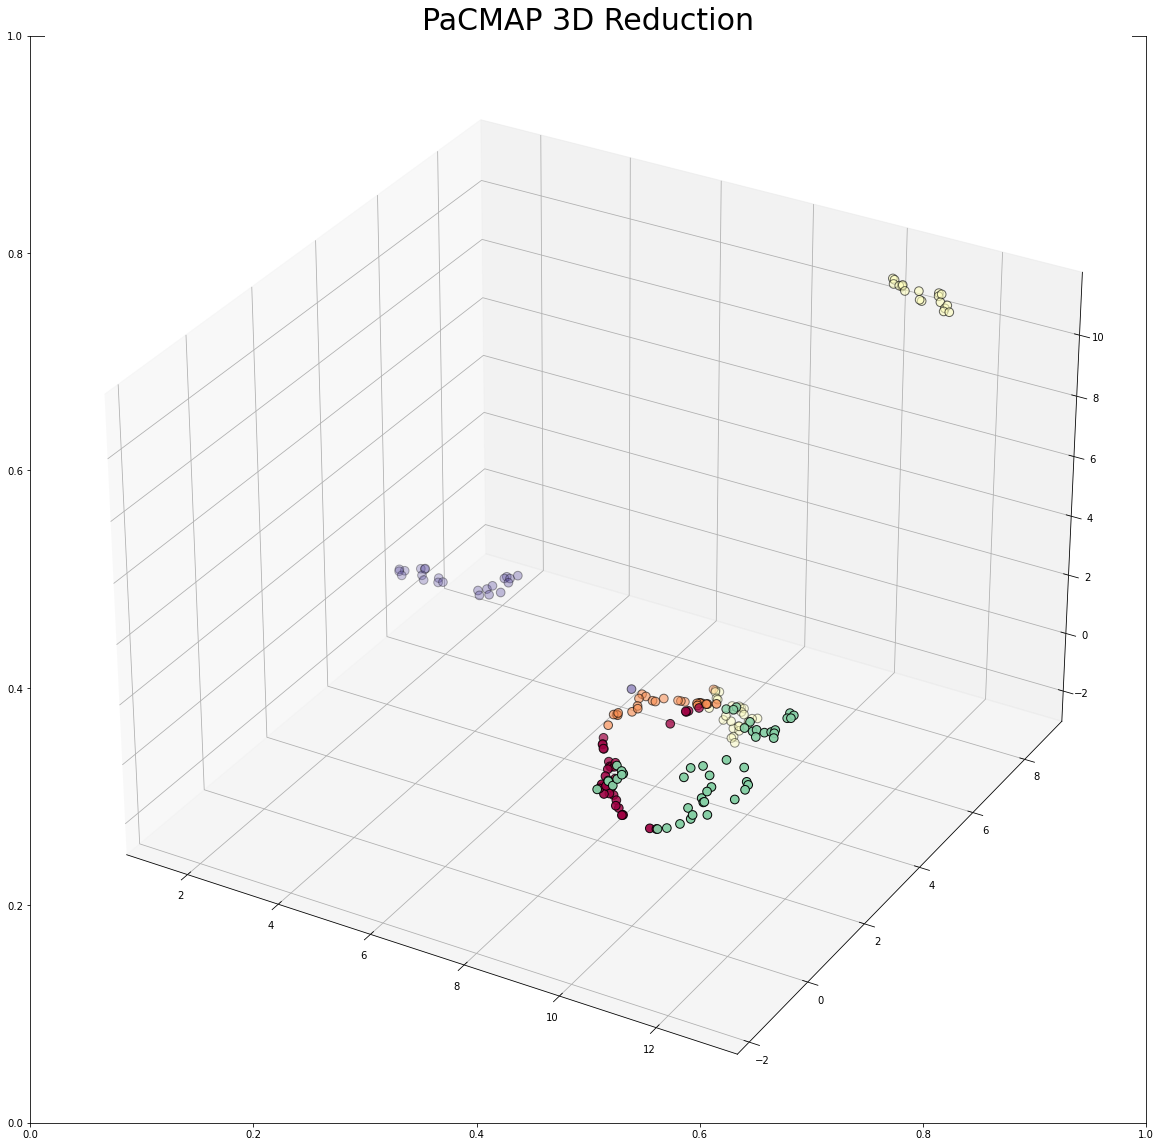

In [ ]:
fig = plt.figure(figsize = (20, 20))
plt.title("PaCMAP 3D Reduction", fontsize=30)
ax = plt.axes(projection ="3d")
ax.scatter3D(df_embedding['x'], df_embedding['y'], df_embedding['z'], c=df_embedding['clusters'], cmap='Spectral', s=75, edgecolors='black')

In [ ]:
%%time
df_embedding=compute_umap(data=train_data, n_components=2, n_neighbors=10, min_dist=0.1, random_state=42)
df_embedding = df_embedding.join(df_images)
df_embedding = df_embedding.join(clusters)
df_embedding.head()

CPU times: total: 594 ms
Wall time: 591 ms


,x,y,image,image_path,generated_path,clusters
0,15.835310,10.136768,G001.9+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G001.9+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G001.9+00.3.png,2
1,11.507137,-2.383005,G003.7-00.2.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.7-00.2.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.7-00.2.png,3
2,9.779799,-3.672250,G003.8+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G003.8+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G003.8+00.3.png,3
3,7.400843,-2.020799,G005.5+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G005.5+00.3.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G005.5+00.3.png,0
4,16.375458,10.518186,G006.1+00.5.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\images\G006.1+00.5.png,C:\Users\aprez\B2Drop\embeddings\astro_embeddings\ld64\generated\G006.1+00.5.png,2


In [ ]:
output_file('plot.html')
curdoc().theme = 'dark_minimal'
datasource =  ColumnDataSource(data=dict(index=df_embedding.index,
                                         x=df_embedding.x,
                                         y=df_embedding.y,
                                         image=df_embedding.image,
                                         clusters=df_embedding.clusters,
                                         image_path=df_embedding.image_path,
                                         gen_path=df_embedding.generated_path,
                                         color=[Category20[20][i+1] for i in df_embedding['clusters']]))

plot_figure = figure(plot_width=800, plot_height=800, tools=('pan, wheel_zoom, reset, save'))
color_mapping = CategoricalColorMapper(factors=[(x) for x in 'clusters'], palette=Category20[3])

plot_figure.add_tools(HoverTool(tooltips="""
<div style='text-align:center; border: 2px solid; border-radius: 2px'>
   <div style='display:flex'> 
    <div>
        <img src='@image_path' width="192" style='display: block; margin: 2px auto auto auto;'/>
    </div>
    <div>
        <img src='@gen_path' width="192" style='display: block; margin: 2px auto auto auto;'/>
    </div>
    </div>
    <div style='padding: 2px; font-size: 12px; color: #000000'>
        <span>Cluster:</span>
        <span>@clusters</span><br>
        <span>X:</span>
        <span>@x</span><br>
        <span>Y:</span>
        <span>@y</span><br>
        <span>Image:</span>
        <span>@image</span>
    </div>
</div>
"""))

plot_figure.circle('x', 'y', source=datasource, color='color', legend_field='clusters', fill_alpha=0.5, size=5)
plot_figure.legend.title = "Clusters"
plot_figure.legend.label_text_color = "black"
plot_figure.legend.background_fill_color = 'white'
plot_figure.legend.background_fill_alpha = 0.5

show(plot_figure)